<IPython.core.display.Javascript object>


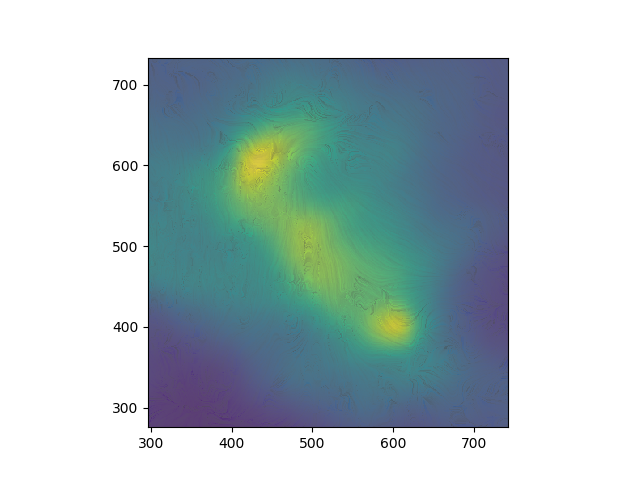

interactive(children=(IntSlider(value=100, continuous_update=False, description='kernellen', max=200, min=5, s…

In [41]:
%matplotlib notebook
import numpy as np
from astropy.io import fits
from astropy.table import Table
#from yt.utilities.lib.line_integral_convolution import line_integral_convolution_2d
from liccy import line_integral_convolution_2d
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy.nddata import block_replicate
from scipy.interpolate import griddata
from ipywidgets import interact, IntSlider, fixed, FloatSlider,Checkbox
from matplotlib import colors


def upsample(data,block, method='cubic'):
    points,values = zip(*np.ndenumerate(data))
    points = np.array(points)
    values = np.array(values)

    grid_x,grid_y = np.mgrid[0:data.shape[0]:data.shape[0]*block*1j,
                             0:data.shape[1]:data.shape[1]*block*1j]

    real_idx = np.array([~np.isnan(v) for v in values])

    points = points[real_idx]
    values = values[real_idx]

    pf = griddata(points,values,(grid_x,grid_y),method=method)
    return pf
    

hdu = fits.open('sofia_data/F0485_HA_POL_76000110_HAWAHWPA_PMP_043-052.fits')

block = 10

stokes_i = hdu['STOKES I'].data

#stokes_i = block_replicate(stokes_i,block)

p = hdu['DEBIASED PERCENT POL'].data
theta = hdu['ROTATED POL ANGLE'].data

#plt.imshow(theta,origin='lower')

stokes_if = upsample(stokes_i,block)
pf = upsample(p, block)
tf = upsample(theta,block)
#plt.figure()
#plt.imshow(tf,origin='lower')
#plt.show()

u = pf*np.cos(tf*np.pi/180)
v = pf*np.sin(tf*np.pi/180)

vectors = np.concatenate((u[...,np.newaxis],
                          v[...,np.newaxis]),axis=2)


fig = plt.figure()
im = plt.imshow(stokes_if,origin='lower')

plotted = [im]

texture = np.random.rand(pf.shape[0],pf.shape[1]).astype(np.double)

def plot_lic(vectors,kernellen,shape,texture=None,lim=(0,1),alpha=0.75,cmap='binary',constant_alpha=False):
    if texture is None:
        texture = np.random.rand(shape[0],shape[1]).astype(np.double)
    
    kernel = np.sin(np.arange(kernellen)*np.pi/kernellen)
    
    lic_data = line_integral_convolution_2d(vectors, texture, kernel)
    lic_data = lic_data / np.nanmax(lic_data)
    
    #lim = (0,1)
    #alpha = 0.75
    #cmap = 'binary'
    
    lic_data_clip = np.clip(lic_data,lim[0],lim[1])
    
    if constant_alpha:
        lic_data_rgba = lic_data_clip
    else:
        
        cmapf = plt.get_cmap(cmap)
        new_cmap = colors.LinearSegmentedColormap.from_list('trunc(%s,0.3,0.7)'%
                                                    cmap,cmapf(np.linspace(0.3,0.7,100)))
        lic_data_rgba = cm.ScalarMappable(norm=None,cmap=new_cmap).to_rgba(lic_data_clip)
        lic_data_clip_rescale = (lic_data_clip - lim[0]) / (lim[1] - lim[0])
        lic_data_rgba[...,3] = lic_data_clip_rescale * alpha

    ## this is just for the interactive widget
    if len(plotted) == 2:
        plotted.pop().remove()
    #plt.imshow(stokes_if,origin='lower')
    lines = plt.imshow(lic_data_rgba,origin='lower',cmap=cmap,alpha=alpha,interpolation='none')
    plotted.append(lines)
    
    
kslider = IntSlider(min=5,max=200,step=5,value=100,description='kernellen',continuous_update=False)
aslider = FloatSlider(min=0.05,max=1,value=0.85,step=0.05,description='alpha')
    
widget = interact(plot_lic,vectors=fixed(vectors),
                  kernellen=kslider,
                  shape=fixed(pf.shape),
                  texture=fixed(texture),
                  lim=fixed((0,1)),
                  alpha=aslider,
                  cmap=fixed('binary'),
                  constant_alpha=Checkbox(
                                    value=False,
                                    description='Constant alpha')
                 )